# Semantic Segmentation of Human Images 2/3 - Training UNET on Supervisely Dataset
### SCS_3546_007 Deep Learning - Prof. Sina Jamshidi - April 2019
### Bruno Schrappe - March 2020

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Using the Supervisely Human labeled dataset
https://supervise.ly/

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Apr  5 01:47:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Images were downloaded and placed on /supervisely-person-dataset/ds1ds2ds6/img

import os
baseDirectory = '/content/gdrive/My Drive/image-segmentation/supervisely-person-dataset/ds1ds2ds6/img-256'
maskDirectory = '/content/gdrive/My Drive/image-segmentation/supervisely-person-dataset/ds1ds2ds6/masks_machine-256'
testDirectory = '/content/gdrive/My Drive/image-segmentation/supervisely-person-dataset/test-images'

In [5]:
# Quick exploration of files and masks to make sure we have the full dataset
print(len(os.listdir(baseDirectory)), 'images.')
print(len(os.listdir(maskDirectory)), 'masks.')

3053 images.
3053 masks.


In [0]:
# Masks are supposed to be all in PNG (non-lossy) format. Just checking...
maskList = os.listdir(maskDirectory)
for filename in maskList:
  if os.path.splitext(filename)[1] != '.png':
    print (filename)

In [0]:
# Using OpenCV to read images and convert them to arrays
import cv2
from matplotlib import pyplot as plt

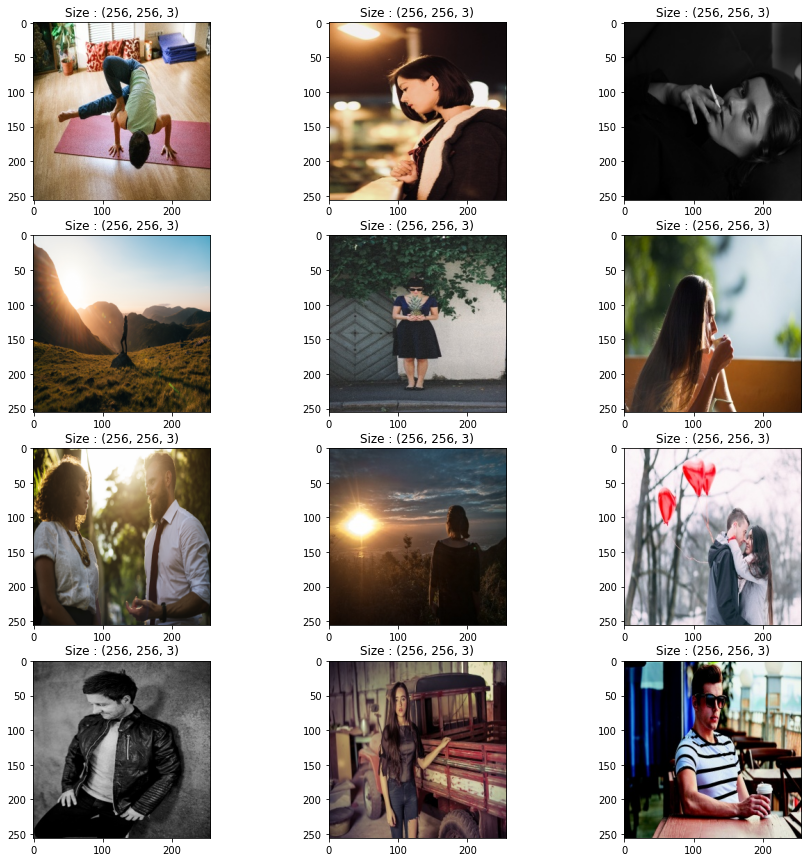

In [8]:
# Just exploring a few images
fileList = os.listdir(baseDirectory)
fig, axs = plt.subplots(4, 3,figsize=(15,15))

index = 0
for i in range(0,4):
    for j in range(0,3):
        filePath = baseDirectory + '/' + fileList[index]
        imageFile = cv2.imread(filePath)
        # Converting to RGB so we can plot it in Matplotlib
        RGB_image = cv2.cvtColor(imageFile, cv2.COLOR_BGR2RGB)
        axs[i,j].imshow(RGB_image)
        axs[i, j].set_title('Size : '+ str(imageFile.shape))
        index += 1

In [0]:
# Dataset preparation
# Images can be in multiple formats (JPEG, PNG, etc)
# Mask files are always in PNG format because it is not subject to lossy compression
# that could potentially change pixel values used for classification (0, 1, 2, etc)
# Please note that both formats are in RGB colorspace

import numpy as np

fileList = os.listdir(baseDirectory)

X = []
y = []

# Scanning image directory (which can have multiple extensions)
for fileName in fileList:
  filePath = baseDirectory + '/' + fileName
  imageFile = cv2.imread(filePath)

  # Images have been resized and saved
  # Include image on X list
  X.append(np.array(imageFile))
    
  # Builds mask file name by forcing extension to .png
  maskFileName = os.path.splitext(fileName)[0] + ".png"
  maskFilePath = maskDirectory + '/' + maskFileName
  maskImageFile = cv2.imread(maskFilePath)
  grayscaleMaskImage = cv2.cvtColor(maskImageFile, cv2.COLOR_RGB2GRAY)
   
  # Include image on y list
  # As we resized in RGB, some edge pixels may have been assigned intermediate values because of anti-alias.
  # Making sure all images have only one class of pixel value=1 assigned 
  mask=[]
  for line in grayscaleMaskImage:
    lineValues=[]
    for pixel in line:
      if pixel != 0:
        lineValues.append([1])
      else:
        lineValues.append([0])
    mask.append(lineValues)

  y.append(mask)

y = np.array(y)

In [10]:
y.shape

(3053, 256, 256, 1)

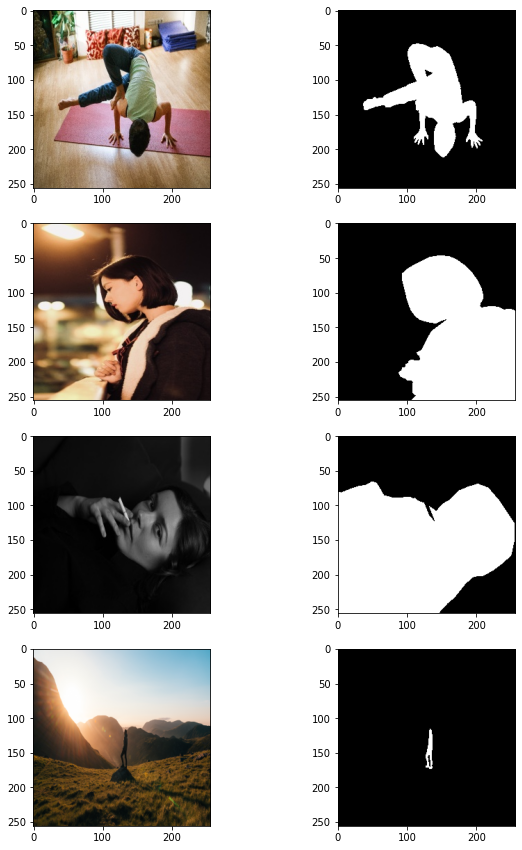

In [10]:
# Sample of processed images and masks
fig, axs = plt.subplots(4, 2,figsize=(10,15))

index = 0
for i in range(0,4):
  axs[i,0].imshow(cv2.cvtColor(X[index], cv2.COLOR_BGR2RGB))
  axs[i,1].imshow(np.squeeze(y[index]),cmap='gray')
  index += 1

In [11]:
# Converting X to tensor and normalizing pixels values to 0-1 (this is easy as the max RGB value is 255)
X = np.array(X) / 255.0
X.shape

(3053, 256, 256, 3)

In [12]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(keras.__version__)

2.2.0-rc2
2.3.0-tf


In [13]:
# Assembling the UNET Model using Keras
# Input shape left as variable as the first layer is convoluted - so it will accept variable-size images

inputs = keras.layers.Input(shape=(None, None, 3))
conv1 = keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = keras.layers.Dropout(0.5)(conv4)
pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = keras.layers.Dropout(0.5)(conv5)

up6 = keras.layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(drop5))
merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
conv6 = keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv6))
merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
conv7 = keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv7))
merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
conv8 = keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv8))
merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
conv9 = keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = keras.layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = keras.layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = keras.Model(inputs = inputs, outputs = conv10)  
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

Using TensorFlow backend.


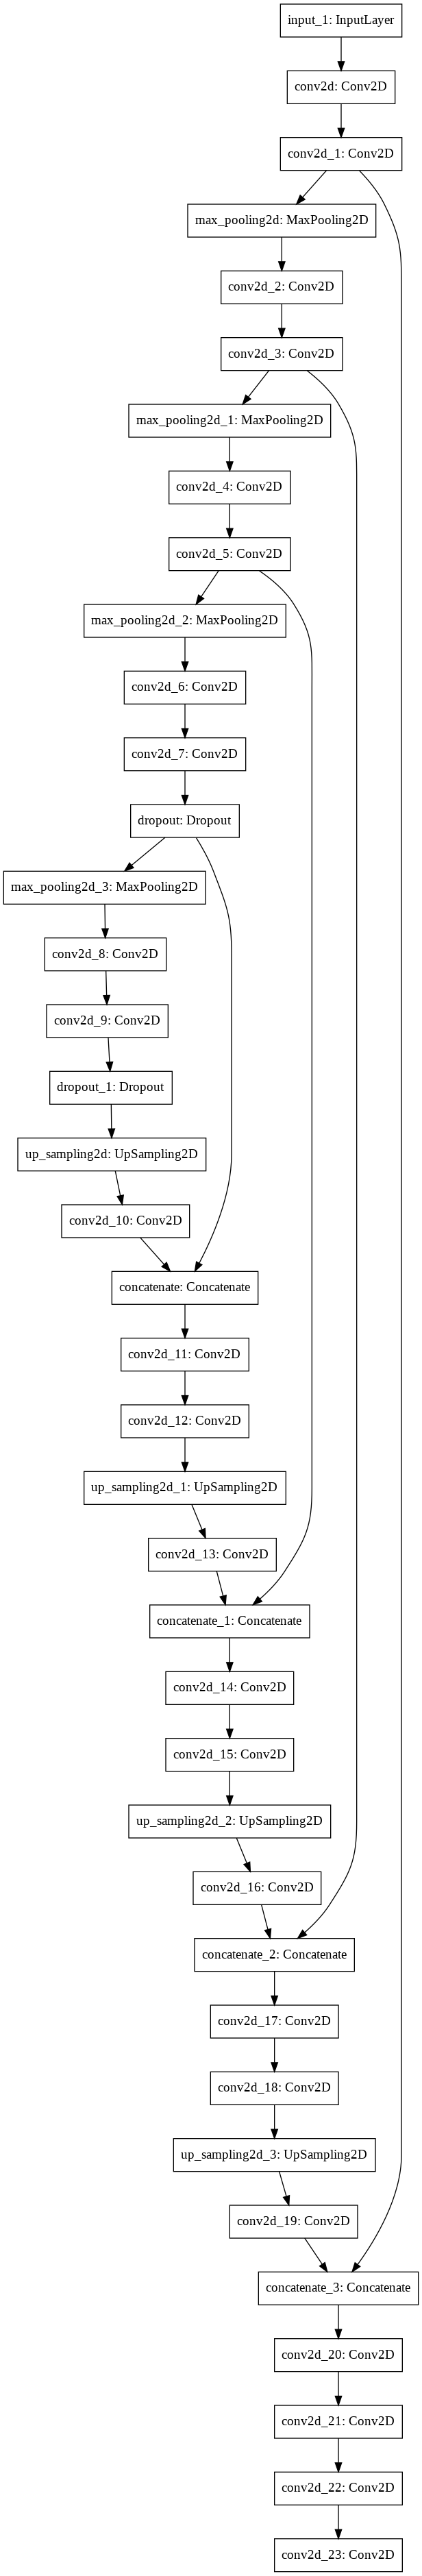

In [14]:
from keras.utils import plot_model
tf.keras.utils.plot_model(model, to_file='/content/gdrive/My Drive/image-segmentation/unet_model.png')

In [15]:
tf.executing_eagerly()

True

In [0]:
# Compile model with ADAM optimizer on binary crossentropy (we are using only one mask class)
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])  

In [17]:
# Train the beast

# Implementing callbacks checking from validation accuracy improvements and saving the best model based on training loss
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True), tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/image-segmentation/unet_people_variable.hdf5', monitor='loss',verbose=1, save_best_only=True)]

# Train saving history, setting validation size to 10% and using callbacks
history = model.fit(X, y, validation_split=0.1, batch_size=20, epochs=100, callbacks=callbacks_list, verbose=1)


Epoch 1/100
138/138 [==============================] - ETA: 0s - loss: 0.5160 - accuracy: 0.7460
Epoch 00001: loss improved from inf to 0.51604, saving model to /content/gdrive/My Drive/image-segmentation/unet_people_variable.hdf5
138/138 [==============================] - 113s 821ms/step - loss: 0.5160 - accuracy: 0.7460 - val_loss: 0.4716 - val_accuracy: 0.7228
Epoch 2/100
138/138 [==============================] - ETA: 0s - loss: 0.4337 - accuracy: 0.7589
Epoch 00002: loss improved from 0.51604 to 0.43371, saving model to /content/gdrive/My Drive/image-segmentation/unet_people_variable.hdf5
138/138 [==============================] - 104s 752ms/step - loss: 0.4337 - accuracy: 0.7589 - val_loss: 0.4377 - val_accuracy: 0.7843
Epoch 3/100
138/138 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0.8212
Epoch 00003: loss improved from 0.43371 to 0.40684, saving model to /content/gdrive/My Drive/image-segmentation/unet_people_variable.hdf5
138/138 [====================

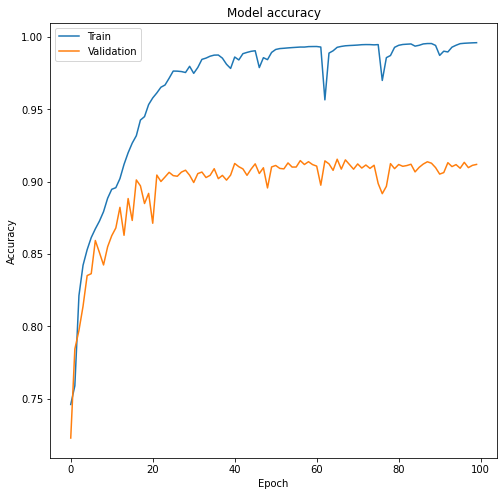

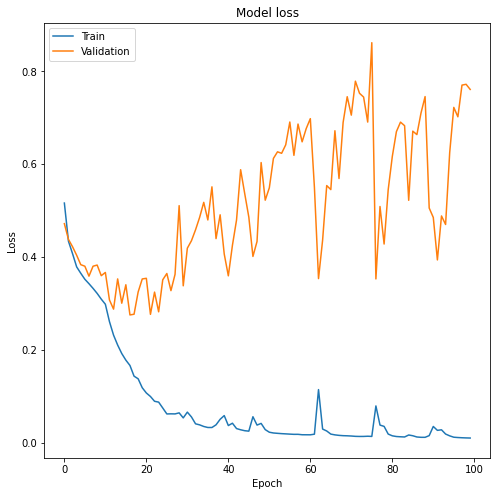

In [20]:
# Plot Training and Validation Accuracy and Loss
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,8)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Although the model came very close to overfitting, validation accuracy slightly increased over 100 epochs. Let's see what predictions look like:

In [21]:
# Scanning test image directory
# Test images can have variable dimensions as long as sides are divisible by 2 multiple times due to necessary convolutions and maxpooling kernels
# Acceptable sizes are 256 (basic dimension we trained the model with), 384, 512, 768, 1024, 1536, etc...

testDirectory = '/content/gdrive/My Drive/image-segmentation/supervisely-person-dataset/test-256-min'

fileList = os.listdir(testDirectory)

# Count images on test folder
numImages = len(fileList)

# Prepare the output
fig, axs = plt.subplots(numImages, 4,figsize=(40, numImages * 9))

for i in range(0,numImages):

  filePath = testDirectory + '/' + fileList[i]
  imageFile = cv2.imread(filePath)
  imageTensor = []
  imageTensor.append(np.array(imageFile)/255.0)
  predMask = model.predict(np.array(imageTensor))[0]

  # This is a neat trick: whilst the UNET output shape is (255,255,1), the actual image is (255,255) where each element has a value.
  # Numpy has a neat "squeeze" feature to scalarize vectors that is very efficient
  # np.squeeze([[1]]) = [1]
  testMaskImages = (np.squeeze(predMask) * 255).astype('uint8')

  # Predicted segmentation mask from the model
  axs[i, 0].imshow(testMaskImages,cmap='gray')
  axs[i, 0].set_title('Predicted Mask')

  # Binary mask (after threshold)
  binaryImages = cv2.threshold(testMaskImages,127, 255,cv2.THRESH_BINARY)[1]
  axs[i, 1].imshow(binaryImages)
  axs[i, 1].set_title('Binary Mask')

  # Read original file
  RGB_image = cv2.cvtColor(imageFile, cv2.COLOR_BGR2RGB)
  axs[i,2].imshow(RGB_image)
  axs[i, 2].set_title('Test Image')

  # Inverted binary mask to be used on background extraction
  invertedMask = cv2.bitwise_not(binaryImages)

  # White image to be used as a background. It needs the same shape as the input image
  white_bg = 255 * np.ones(shape=imageTensor[0].shape , dtype=np.uint8)

  # Resulting image with black background
  image_black_background = cv2.bitwise_or(imageFile, imageFile, mask = binaryImages)

  # White background AND inverted mask
  white_background = cv2.bitwise_and(white_bg, white_bg, mask=invertedMask)
  
  # Final image with bitwise OR
  finalImage = cv2.bitwise_or(image_black_background, white_background)

  RGB_image = cv2.cvtColor(finalImage, cv2.COLOR_BGR2RGB)
  axs[i,3].imshow(RGB_image)
  axs[i, 3].set_title('Masked Image')

Output hidden; open in https://colab.research.google.com to view.

### Actually, not too bad for a first iteration. 
### Clearly, some image features were not learned by convolutions on the limited training data set.We need more training data, so we will resort image data augmentation.
## Image Data Augmentation

In [0]:
from tensorflow.keras.preprocessing import image

train_size = 2750

# Training data will be X[0:train_size]
# Validation data will be X[train_size:]

# Training masks will be y[0:train_size]
# Validation masks will be y[train_size:]

# Augmenting the dataset
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=20, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=20, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together
image_datagen.fit(X[0:train_size], augment=True, seed=42)
mask_datagen.fit(y[0:train_size], augment=True, seed=42)

augmented_X_train = image_datagen.flow(X[0:train_size],batch_size=20,shuffle=True, seed=42)
augmented_y_train = mask_datagen.flow(y[0:train_size],batch_size=20,shuffle=True, seed=42)

train_generator = zip(augmented_X_train, augmented_y_train)

In [14]:
len(augmented_X_train)

138

In [0]:
# Assembling the UNET Model using Keras
# Input shape left as variable as the first layer is convoluted - so it will accept variable-size images

inputs = keras.layers.Input(shape=(None, None, 3))
conv1 = keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = keras.layers.Dropout(0.5)(conv4)
pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = keras.layers.Dropout(0.5)(conv5)

up6 = keras.layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(drop5))
merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
conv6 = keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv6))
merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
conv7 = keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv7))
merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
conv8 = keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv8))
merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
conv9 = keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = keras.layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = keras.layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = keras.Model(inputs = inputs, outputs = conv10) 

In [0]:
# Compile model with ADAM optimizer on binary crossentropy (we are using only one mask class)
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])  

In [27]:
# Train the beast with additional generated images

# Implementing callbacks checking from validation accuracy improvements and saving the best model based on training loss
callbacks_list = [tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/image-segmentation/unet_people_variable_augmented.hdf5', monitor='loss',verbose=1, save_best_only=True)]

history = model.fit(train_generator, validation_data=(X[train_size:], y[train_size:]), epochs=200, steps_per_epoch= 100, callbacks=callbacks_list)

Epoch 1/200
100/100 [==============================] - ETA: 0s - loss: 0.5490 - accuracy: 0.7372
Epoch 00001: loss improved from inf to 0.54904, saving model to /content/gdrive/My Drive/image-segmentation/unet_people_variable_augmented.hdf5
100/100 [==============================] - 75s 752ms/step - loss: 0.5490 - accuracy: 0.7372 - val_loss: 0.5314 - val_accuracy: 0.7205
Epoch 2/200
100/100 [==============================] - ETA: 0s - loss: 0.4694 - accuracy: 0.7368
Epoch 00002: loss improved from 0.54904 to 0.46942, saving model to /content/gdrive/My Drive/image-segmentation/unet_people_variable_augmented.hdf5
100/100 [==============================] - 75s 750ms/step - loss: 0.4694 - accuracy: 0.7368 - val_loss: 0.4561 - val_accuracy: 0.7205
Epoch 3/200
100/100 [==============================] - ETA: 0s - loss: 0.4493 - accuracy: 0.7332
Epoch 00003: loss improved from 0.46942 to 0.44926, saving model to /content/gdrive/My Drive/image-segmentation/unet_people_variable_augmented.hdf5
1

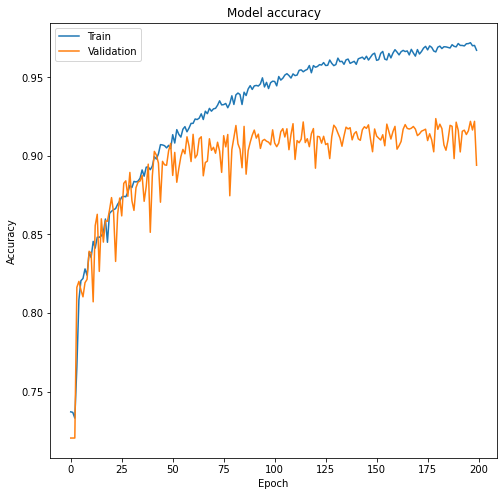

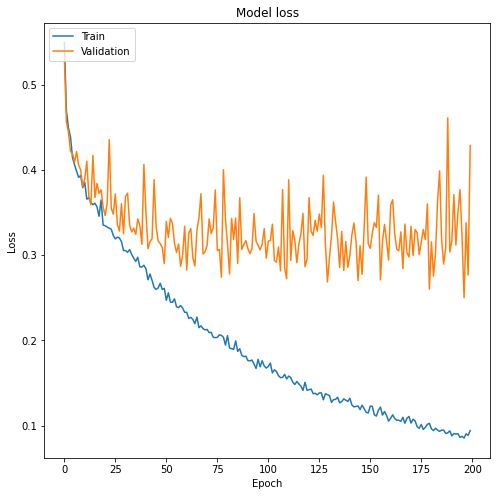

In [28]:
# Plot Training and Validation Accuracy and Loss.
plt.rcParams["figure.figsize"] = (8,8)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
model = keras.models.load_model('/content/gdrive/My Drive/image-segmentation/unet_people_variable_augmented.hdf5')

In [32]:
# It is lame to repeat code to show predictions here, but I don't intend to repurpose this again. 
# Scanning test image directory...
# Test images can have variable dimensions as long as sides are divisible by 2 multiple times due to necessary convolutions and maxpooling kernels
# Acceptable sizes are 256 (basic dimension we trained the model with), 384, 512, 768, 1024, 1536, etc...

testDirectory = '/content/gdrive/My Drive/image-segmentation/supervisely-person-dataset/test-256-min'

fileList = os.listdir(testDirectory)

# Count images on test folder
numImages = len(fileList)

# Prepare the output
fig, axs = plt.subplots(numImages, 4,figsize=(40, numImages * 9))

for i in range(0,numImages):

  filePath = testDirectory + '/' + fileList[i]
  imageFile = cv2.imread(filePath)
  imageTensor = []
  imageTensor.append(np.array(imageFile)/255.0)
  predMask = model.predict(np.array(imageTensor))[0]

  # This is a neat trick: whilst the UNET output shape is (255,255,1), the actual image is (255,255) where each element has a value.
  # Numpy has a neat "squeeze" feature to scalarize vectors that is very efficient
  # np.squeeze([[1]]) = [1]
  testMaskImages = (np.squeeze(predMask) * 255).astype('uint8')

  # Predicted segmentation mask from the model
  axs[i, 0].imshow(testMaskImages,cmap='gray')
  axs[i, 0].set_title('Predicted Mask')

  # Binary mask (after threshold)
  binaryImages = cv2.threshold(testMaskImages,127, 255,cv2.THRESH_BINARY)[1]
  axs[i, 1].imshow(binaryImages)
  axs[i, 1].set_title('Binary Mask')

  # Read original file
  RGB_image = cv2.cvtColor(imageFile, cv2.COLOR_BGR2RGB)
  axs[i,2].imshow(RGB_image)
  axs[i, 2].set_title('Test Image')

  # Inverted binary mask to be used on background extraction
  invertedMask = cv2.bitwise_not(binaryImages)

  # White image to be used as a background. It needs the same shape as the input image
  white_bg = 255 * np.ones(shape=imageTensor[0].shape , dtype=np.uint8)

  # Resulting image with black background
  image_black_background = cv2.bitwise_or(imageFile, imageFile, mask = binaryImages)

  # White background AND inverted mask
  white_background = cv2.bitwise_and(white_bg, white_bg, mask=invertedMask)
  
  # Final image with bitwise OR
  finalImage = cv2.bitwise_or(image_black_background, white_background)

  RGB_image = cv2.cvtColor(finalImage, cv2.COLOR_BGR2RGB)
  axs[i,3].imshow(RGB_image)
  axs[i, 3].set_title('Masked Image')

Output hidden; open in https://colab.research.google.com to view.

#Conclusions
##The feasibility of using UNET for semantic segmentation with a fair degree of masking accuracy has been proven.
We achieved better results augmenting the dataset using Keras' ImageGenerator. However, the model could be further improved by using a larger dataset (only a subset of available images from the Supervisely Human dataset was used) and higher resolution masks.


## References

Mask R-CNN: 
https://arxiv.org/abs/1703.06870

Understanding Semantic Segmentation with UNET:
https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

Mask-RCNN and U-net Ensembled for Nuclei Segmentation: https://arxiv.org/abs/1901.10170

A Keras Pipeline for Image Segmentation: https://towardsdatascience.com/a-keras-pipeline-for-image-segmentation-part-1-6515a421157d

Background removal with deep learning: https://towardsdatascience.com/background-removal-with-deep-learning-c4f2104b3157

Releasing “Supervisely Person” dataset for teaching machines to segment humans: https://hackernoon.com/releasing-supervisely-person-dataset-for-teaching-machines-to-segment-humans-1f1fc1f28469

U-Net: Convolutional Networks for Biomedical Image Segmentation: https://arxiv.org/pdf/1505.04597.pdf

Coco Dataset: http://cocodataset.org/

Practical Image Segmentation with UNET: https://tuatini.me/practical-image-segmentation-with-unet/

nnU-Net: Self-adapting Framework for U-Net-Based Medical Image Segmentation
https://arxiv.org/abs/1809.10486

Semantic Soft Segmentation: 
http://cfg.mit.edu/sites/cfg.mit.edu/files/sss_3.pdf


### Run this Javascript code on browser Console to prevent disconnecting after 90 min: 

function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("Put ID here").click() // Change id here
}
setInterval(ClickConnect,60000)